<a href="https://colab.research.google.com/github/haedal-uni/analysis/blob/main/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://darktrader.tistory.com/entry/%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A1%9C-%EB%B3%B4%EB%8A%94-%EB%AF%B8%EB%9E%98-%EA%B2%BD%EC%A0%9C-%EC%88%9C%ED%99%98%EC%9D%84-%EB%B0%98%EC%98%81%ED%95%9C-%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90-%EC%A3%BC%EA%B0%80-%EC%98%88%EC%B8%A1-Prophet-%EB%AA%A8%EB%8D%B8-%ED%99%9C%EC%9A%A9

링크를 보고 실행

In [5]:
import warnings
import matplotlib
import sys
import numpy as np
import os
import pandas as pd

warnings.filterwarnings(action='ignore')

if 'google.colab' in sys.modules:
    !echo 'debconf debconf/frontend select Noninteractive' | debconf-set-selections
    # 나눔 폰트를 설치
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

matplotlib.rcParams['font.family'] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

import pandas as pd
df = pd.read_csv('미국 철강 코일 선물 과거 데이터.csv', thousands=",") # 구분자 제거
df = df.sort_index()
df['날짜'] = pd.to_datetime(df['날짜'])
df.head()

,날짜,종가,시가,고가,저가,거래량,변동 %
0,2025-04-07,930.0,930.0,935.0,925.0,0.01K,-0.21%
1,2025-04-04,932.0,913.0,945.0,905.0,0.14K,2.08%
2,2025-04-03,913.0,913.0,914.0,913.0,0.01K,-0.22%
3,2025-04-02,915.0,897.0,920.0,897.0,0.11K,2.23%
4,2025-04-01,895.0,894.0,895.0,894.0,0.07K,0.56%


DEBUG:cmdstanpy:input tempfile: /tmp/tmpwn2m21sg/001s_gkr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwn2m21sg/lmw9sl3j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8994', 'data', 'file=/tmp/tmpwn2m21sg/001s_gkr.json', 'init=/tmp/tmpwn2m21sg/lmw9sl3j.json', 'output', 'file=/tmp/tmpwn2m21sg/prophet_modelwwo1w87n/prophet_model-20250408050820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:08:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:08:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


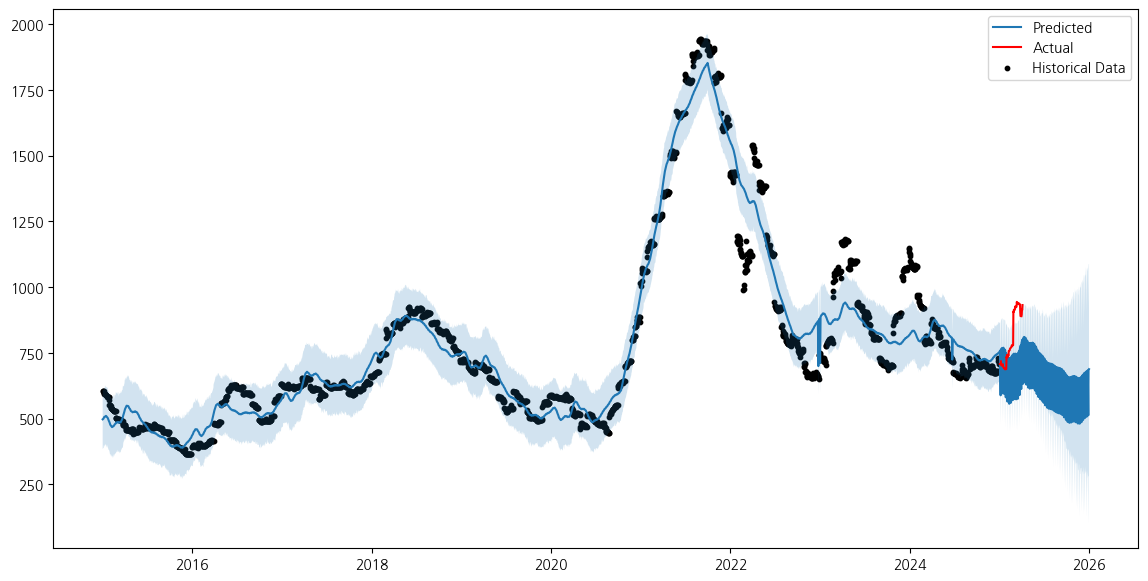

In [7]:
from prophet import Prophet
import matplotlib.pyplot as plt

# prophet 모델에 맞게 ds와 y 컬럼 지정
## 예측의 시작점을 2025년 1월 1일로 설정
df_train = df[df['날짜'] < '2025-01-01'][["날짜", "종가"]]
df_train = df_train.rename(columns={"날짜": "ds", "종가": "y"})

# prophet 모델 생성 및 학습(default values)
m = Prophet(
    # changepoint_prior_scale: 트렌드의 유연성을 조절하는 파라미터로, 이 값을 조정함으로써
    # 모델이 트렌드 변화를 얼마나 민감하게 감지할지 결정할 수 있다.

    changepoint_prior_scale=0.05,
    # weekly_seasonality: 주간 데이터의 계절성을 나타냅니다.
    # 데이터가 일별 데이터로 날짜가 길면 weekly_seasonality = True로 설정한다

    weekly_seasonality=10,
    # 연간 데이터의 계절성을 나타냅니다.
    # 데이터가 연간 데이터로 이루어져 있으면 yearly_seasonality = True로 설정한다

    yearly_seasonality=10,
    # 일간 데이터의 계절성을 나타냅니다.
    # 데이터가 일별 데이터면 daily_seasonality = True로 설정한다

    daily_seasonality=10,
    # 가법 모델(additive model) : 일반적 시계열, y(t)=g(t)+s(t)+h(t)+ϵ_t
    # 승법 모델(multiplicative model) : 계절성 요소가 시간에 따라 변하는 트렌드의 크기에
    # 비례하여 변화하는 시계열, y(t)=g(t)⋅s(t)⋅h(t)⋅ϵ_t
    seasonality_mode='additive'
)
m.fit(df_train)

# 향후 365일간의 주가 예측
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

# 실제 데이터와 예측 데이터 병합
df_test = df[df['날짜'] >= '2025-01-01'][["날짜", "종가"]]
df_test = df_test.rename(columns={"날짜": "ds", "종가": "Actual"})
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
merged = pd.merge(forecast, df_test, on='ds', how='left')

# 예측 결과 및 실제 주가 시각화
plt.figure(figsize=(14, 7))
plt.plot(merged['ds'], merged['yhat'], label='Predicted')  # 파란 선 (예측값)
plt.plot(merged['ds'], merged['Actual'], label='Actual', color='r') # 빨간 선 (실제값)
plt.scatter(df_train['ds'], df_train['y'], color='black', s=10, label='Historical Data')  # 검은 점 (과거 데이터)
plt.fill_between(merged['ds'], merged['yhat_lower'], merged['yhat_upper'], alpha=0.2) # 예측 구간
plt.legend()
plt.show()

- 파란 선 (Predicted)

Prophet이 예측한 **중심값(yhat)**이다.

전체적으로 완만한 하향 추세 또는 횡보 흐름으로 보인다.

<br>

- 빨간 선 (Actual)

실제 주가 데이터다 (2025년 이후).

예측과 비교했을 때 실제 데이터가 살짝 상단으로 벗어난 구간이 존재한다.

➡ 예측보다 실제 가격이 조금 더 빠르게 상승한 패턴이 일부 구간에서 확인된다.

<br>

- 검은 점 (Historical Data)

2025년 이전의 실제 주가

Prophet 모델이 이 데이터를 기반으로 패턴을 학습한 것이다.

<br>

- 음영 구간 (yhat_lower ~ yhat_upper)

예측의 **불확실성 구간 (Confidence Interval)**이다.

진한 파랑 영역 안에 실제값이 포함된다면 모델이 비교적 정확하다고 볼 수 있다.

➡ 빨간 Actual 선이 음영 영역을 대부분 포함하고 있어 예측 신뢰도는 양호

Prophet은 ds (날짜), y (예측 대상 값)이라는 컬럼명을 사용해야 한다.

<br>

2025년 1월 1일 이전 데이터를 학습용으로 사용

<br>

```py
m = Prophet(
    changepoint_prior_scale=0.05,
    weekly_seasonality=10,
    yearly_seasonality=10,
    daily_seasonality=10,
    seasonality_mode='additive'
)
```
changepoint_prior_scale: 트렌드 변화 민감도 조절

계절성 설정: 주간/연간/일간 계절성 모두 포함

additive : 계절성과 트렌드가 단순히 더해지는 방식

<br>

```py
m.fit(df_train)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
```

2025년 1월 1일부터 365일간 예측 진행 (즉, 2025년 12월 31일까지)

forecast는 예측 결과 (yhat, yhat_lower, yhat_upper)를 포함한 데이터프레임이다.

<br>

예측값과 실제값 비교


```py
df_test = df[df['날짜'] >= '2025-01-01'][["날짜", "종가"]]
df_test = df_test.rename(columns={"날짜": "ds", "종가": "Actual"})
```
2025년 이후의 실제 데이터를 `Actual`로 가져온다.
